# ![VGG16 Gradcam - LIME - SHAP](https://miro.medium.com/v2/resize:fit:1400/0*WiQyXNkLZsT6P1Zf.png)

#IMPORT E SETUP

In [5]:
import tensorflow as tf
from PIL import Image
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
from google.colab import drive
import os
from keras.callbacks import ModelCheckpoint
!pip install -q -U keras-tuner
import keras_tuner as kt

In [6]:
from google.colab import drive
import os

# Collegare Google Drive
drive.mount('/content/drive', force_remount=True)

# Creare una cartella chiamata 'AAoMC' su Google Drive per salvare i dati
base_path = "/content/drive/My Drive/AAoMC"
if not os.path.exists(base_path):
    os.makedirs(base_path)


Mounted at /content/drive


#DATASET PREPROCESSING

In [7]:
import os
import zipfile

# Percorsi definiti
base_path = "/content/drive/My Drive/AAoMC"
zip_file_path = os.path.join(base_path, 'dataset_covid.zip')  # Nome del file zip
extract_path = '/content/estrazione/'  # Percorso di estrazione

# Estrazione del file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Creazione degli array per salvare i path delle immagini
positive = []
negative = []
viral_pneumonia = []

# Definizione delle cartelle da cui estrarre i percorsi
covid_path = os.path.join(extract_path, 'COVID/images')  # Cartella COVID
normal_path = os.path.join(extract_path, 'Normal/images')  # Cartella NORMAL
viral_pneumonia_path = os.path.join(extract_path, 'Viral Pneumonia/images')  # Cartella Viral Pneumonia

# Salva i path delle immagini COVID in 'positive'
for root, dirs, files in os.walk(covid_path):
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
            positive.append(os.path.join(root, file))

# Salva i path delle immagini NORMAL in 'negative'
for root, dirs, files in os.walk(normal_path):
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
            negative.append(os.path.join(root, file))

# Salva i path delle immagini Viral Pneumonia in 'viral_pneumonia'
for root, dirs, files in os.walk(viral_pneumonia_path):
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
            viral_pneumonia.append(os.path.join(root, file))

# Stampa il numero di immagini in ciascun array
print(f"Number of positive images (COVID): {len(positive)}")
print(f"Number of negative images (NORMAL): {len(negative)}")
print(f"Number of viral pneumonia images: {len(viral_pneumonia)}")


Number of positive images (COVID): 3616
Number of negative images (NORMAL): 10192
Number of viral pneumonia images: 1345


In [8]:
import pandas as pd

# Creazione delle liste di dizionari con percorsi immagine e etichette (classi)
data = []

# Inserisci tutte le immagini positive (COVID) con label '2'
for img_path in positive:
    data.append({"filename": img_path, "category": "covid"})  # 2 = COVID

# Inserisci tutte le immagini negative (Normal) con label '0'
for img_path in negative:
    data.append({"filename": img_path, "category": "normal"})  # 0 = Normal

# Inserisci tutte le immagini di Viral Pneumonia con label '1'
for img_path in viral_pneumonia:
    data.append({"filename": img_path, "category": "viral_pneumonia"})  # 1 = Viral Pneumonia

# Creazione del DataFrame con tutte le immagini
df = pd.DataFrame(data)

# Mostra le prime righe del DataFrame
print(df.head())

# Stampa il numero di immagini per ogni classe nel DataFrame
print(f"Number of COVID images: {len(df[df['category'] == 'covid'])}")
print(f"Number of NORMAL images: {len(df[df['category'] == 'normal'])}")
print(f"Number of Viral Pneumonia images: {len(df[df['category'] == 'viral_pneumonia'])}")

                                          filename category
0   /content/estrazione/COVID/images/COVID-576.png    covid
1  /content/estrazione/COVID/images/COVID-3386.png    covid
2   /content/estrazione/COVID/images/COVID-547.png    covid
3  /content/estrazione/COVID/images/COVID-2805.png    covid
4  /content/estrazione/COVID/images/COVID-3519.png    covid
Number of COVID images: 3616
Number of NORMAL images: 10192
Number of Viral Pneumonia images: 1345


In [9]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.2, random_state=100)
train, val = train_test_split(train_val, test_size=0.125, random_state=100)

print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 10606
Validation set: 1516
Test set: 3031


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creazione del generatore per il test set
img_generator = ImageDataGenerator(rescale=1./255)  # Normalizzazione delle immagini


# Crea un generatore di dati per il test set utilizzando flow_from_dataframe
train_gen = img_generator.flow_from_dataframe(
    dataframe=train,
    directory="/content",  # Il percorso base che contiene le immagini
    seed=100,  # Seed per riproducibilità
    x_col="filename",  # Colonna con i percorsi delle immagini
    y_col="category",  # Colonna con le etichette delle classi (COVID, NORMAL, Viral Pneumonia)
    target_size=(224, 224),  # Dimensione di input per il modello, ad esempio VGG16
    class_mode="categorical",  # Tipo di classificazione (multi-classe)
    batch_size=32,  # Numero di immagini per batch
    shuffle=True  # Non mescolare i dati durante il test
)

# Crea un generatore di dati per il test set utilizzando flow_from_dataframe
val_gen = img_generator.flow_from_dataframe(
    dataframe=val,
    directory="/content",  # Il percorso base che contiene le immagini
    seed=100,  # Seed per riproducibilità
    x_col="filename",  # Colonna con i percorsi delle immagini
    y_col="category",  # Colonna con le etichette delle classi (COVID, NORMAL, Viral Pneumonia)
    target_size=(224, 224),  # Dimensione di input per il modello, ad esempio VGG16
    class_mode="categorical",  # Tipo di classificazione (multi-classe)
    batch_size=32,  # Numero di immagini per batch
    shuffle=True  # Non mescolare i dati durante il test
)



# Crea un generatore di dati per il test set utilizzando flow_from_dataframe
test_gen = img_generator.flow_from_dataframe(
    dataframe=test,
    directory="/content",  # Il percorso base che contiene le immagini
    seed=100,  # Seed per riproducibilità
    x_col="filename",  # Colonna con i percorsi delle immagini
    y_col="category",  # Colonna con le etichette delle classi (COVID, NORMAL, Viral Pneumonia)
    target_size=(224, 224),  # Dimensione di input per il modello, ad esempio VGG16
    class_mode="categorical",  # Tipo di classificazione (multi-classe)
    batch_size=32,  # Numero di immagini per batch
    shuffle=False  # Non mescolare i dati durante il test
)

# Stampa per confermare
print(f"Number of images in test_gen: {test_gen.samples}")


Found 10606 validated image filenames belonging to 3 classes.
Found 1516 validated image filenames belonging to 3 classes.
Found 3031 validated image filenames belonging to 3 classes.
Number of images in test_gen: 3031


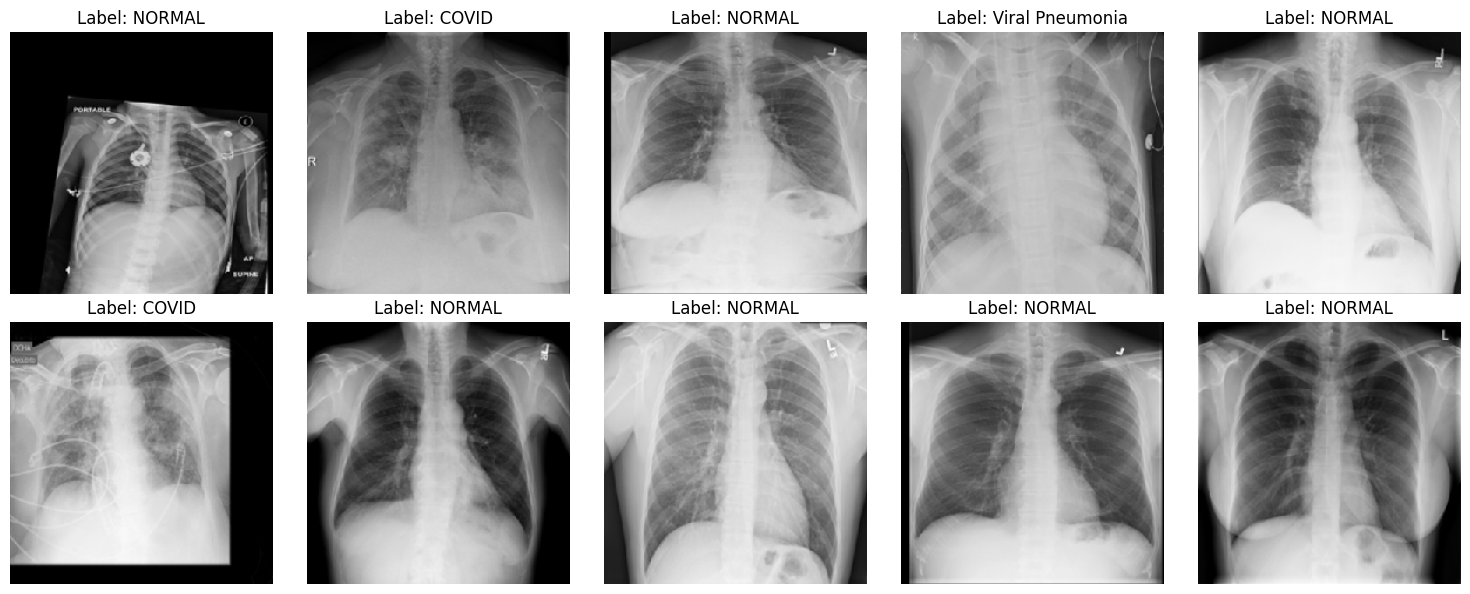

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Preleva casualmente 10 immagini e le rispettive etichette dal generatore
x_batch, y_batch = next(test_gen)  # Preleva un batch di immagini
indices = np.random.choice(range(len(x_batch)), 10, replace=False)  # Seleziona 10 indici casuali

# Creazione del grafico con 2 righe e 5 colonne
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))  # 5 colonne, 2 righe
axes = axes.ravel()  # Flatten per iterare facilmente

# Visualizza le immagini e le etichette
for i, idx in enumerate(indices):
    axes[i].imshow(x_batch[idx])  # Mostra l'immagine
    label = np.argmax(y_batch[idx])  # Trova l'indice della classe predetta (vettore one-hot)

    # Mappa degli indici alle etichette delle classi
    class_labels = ['COVID', 'NORMAL', 'Viral Pneumonia']
    axes[i].set_title(f"Label: {class_labels[label]}")  # Mostra la label
    axes[i].axis('off')  # Rimuovi gli assi

plt.tight_layout()
plt.show()


#MODELLO

In [12]:
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2,2))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_path = "/content/drive/MyDrive/AAoMC/model/myVGG16"

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,305,027 (58.38 MB)

 Trainable params: 590,339 (2.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#TRAINING

###Aux Methods

In [14]:
import os
import re
import pandas as pd
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



class CSVLoggerCallback(Callback):
    def __init__(self, path):
        super(CSVLoggerCallback, self).__init__()
        self.path = path
        self.history_file = os.path.join(self.path, 'training_history.csv')

        # Crea la directory se non esiste
        if not os.path.exists(self.path):
            os.makedirs(self.path)

        # Controllo se il file CSV esiste già
        self.file_exists = os.path.exists(self.history_file)

    def on_epoch_end(self, epoch, logs=None):
        # Estrazione dei dati di interesse alla fine dell'epoca
        logs = logs or {}
        epoch_data = {
            'epoch': [epoch + 1],
            'training_accuracy': [logs.get('accuracy')],
            'training_loss': [logs.get('loss')],
            'validation_accuracy': [logs.get('val_accuracy')],
            'validation_loss': [logs.get('val_loss')]
        }

        # Creiamo un DataFrame per la singola epoca
        epoch_df = pd.DataFrame(epoch_data)

        # Se il file esiste già, appendo i nuovi dati senza intestazione
        if self.file_exists:
            epoch_df.to_csv(self.history_file, mode='a', header=False, index=False)
        else:
            # Se il file non esiste, lo creo con l'intestazione
            epoch_df.to_csv(self.history_file, index=False)
            self.file_exists = True  # Ora il file esiste

        print(f"Salvati i dati dell'epoca {epoch + 1} in {self.history_file}")



def generate_plot(path, epoch=0):
    # Percorso del file CSV contenente la storia dell'addestramento
    history_file = os.path.join(path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if not os.path.exists(history_file):
        print(f"File {history_file} non trovato!")
        return

    # Carica i dati dal file CSV
    try:
        history_df = pd.read_csv(history_file)
    except Exception as e:
        print(f"Errore durante la lettura del CSV: {e}")
        return

    # Verifica che le colonne necessarie esistano nel file CSV
    required_columns = ['epoch', 'training_accuracy', 'validation_accuracy', 'training_loss', 'validation_loss']
    if not all(col in history_df.columns for col in required_columns):
        print("Il file CSV non contiene tutte le colonne richieste.")
        return

    # Determina il numero massimo di epoche presenti nel file
    max_epoch_in_data = history_df['epoch'].max()

    # Se l'epoch specificata è maggiore del numero di epoche disponibili, usa quella massima
    if epoch > 0:
        epoch = min(epoch, max_epoch_in_data)
        history_df = history_df[history_df['epoch'] <= epoch]
    else:
        epoch = max_epoch_in_data  # Usa tutte le epoche se epoch è 0

    # Generazione del grafico di accuracy
    plt.plot(history_df['epoch'], history_df['training_accuracy'], label='Train')
    plt.plot(history_df['epoch'], history_df['validation_accuracy'], label='Validation')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    accuracy_plot_path = os.path.join(path, 'accuracy_plot.png')
    plt.savefig(accuracy_plot_path)
    plt.show()  # Mostra il grafico di accuracy
    plt.close()  # Chiude il grafico corrente
    print(f"Salvato grafico di accuracy in: {accuracy_plot_path}")

    # Generazione del grafico di loss
    plt.plot(history_df['epoch'], history_df['training_loss'], label='Train')
    plt.plot(history_df['epoch'], history_df['validation_loss'], label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    loss_plot_path = os.path.join(path, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.show()  # Mostra il grafico di loss
    plt.close()  # Chiude il grafico corrente
    print(f"Salvato grafico di loss in: {loss_plot_path}")




def show_plots(path):
    # Percorso dei file di grafici salvati
    accuracy_plot_path = os.path.join(path, 'accuracy_plot.png')
    loss_plot_path = os.path.join(path, 'loss_plot.png')

    # Controlla e mostra il grafico di accuracy
    if os.path.exists(accuracy_plot_path):
        accuracy_img = mpimg.imread(accuracy_plot_path)
        plt.imshow(accuracy_img)
        plt.axis('off')  # Rimuove gli assi
        plt.title('Model Accuracy')
        plt.show()  # Mostra il grafico di accuracy
    else:
        print(f"Grafico di accuracy non trovato in: {accuracy_plot_path}")

    # Controlla e mostra il grafico di loss
    if os.path.exists(loss_plot_path):
        loss_img = mpimg.imread(loss_plot_path)
        plt.imshow(loss_img)
        plt.axis('off')  # Rimuove gli assi
        plt.title('Model Loss')
        plt.show()  # Mostra il grafico di loss
    else:
        print(f"Grafico di loss non trovato in: {loss_plot_path}")




def get_latest_epoch_number(folder_path):
    # Percorso del file CSV
    history_file = os.path.join(folder_path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if not os.path.exists(history_file):
        return None  # Se il file non esiste, restituisci None

    # Legge il file CSV
    try:
        history_df = pd.read_csv(history_file)

        # Controlla se ci sono dati nel file CSV
        if history_df.empty:
            return None  # Se il CSV è vuoto, restituisci None

        # Ottiene l'ultima epoca dal campo 'epoch'
        last_epoch = history_df['epoch'].iloc[-1]  # Legge l'ultima riga del campo 'epoch'

        return f"{int(last_epoch):02d}"  # Restituisce l'epoca formattata con due cifre
    except Exception as e:
        print(f"Errore durante la lettura del CSV: {e}")
        return None




def get_best_epoch_number(folder_path):
    # Espressione regolare per trovare i file con il pattern "model_epoch_0N.keras"
    pattern = r'model_epoch_(\d+)\.keras'

    # Lista per tenere traccia dei numeri di epoca
    epoch_numbers = []

    # Cerca i file nella cartella
    for filename in os.listdir(folder_path):
        # Cerca una corrispondenza con il pattern
        match = re.match(pattern, filename)
        if match:
            epoch_num = int(match.group(1))  # Estrae il numero dell'epoca
            epoch_numbers.append(epoch_num)

    # Controlla se ci sono file corrispondenti
    if not epoch_numbers:
        return None  # Nessun file trovato con il pattern

    # Restituisce il numero di epoca maggiore, formattato sempre con due cifre
    latest_epoch = max(epoch_numbers)
    return f"{latest_epoch:02d}"  # Formatta il numero con due cifre




def load_model(model, model_path):
    # Carica il modello dai pesi salvati
    best_model = get_best_epoch_number(model_path)
    model.load_weights(os.path.join(model_path, "model_epoch_" + best_model + ".keras"))

    # Stampare il sommario del modello
    print(model.summary())

    # Percorsi dei grafici salvati
    accuracy_path = os.path.join(os.path.dirname(model_path), 'accuracy_plot.png')
    loss_path = os.path.join(os.path.dirname(model_path), 'loss_plot.png')

    # Mostra i plot
    show_plots(model_path)

    # Percorso del file CSV con la storia del training
    history_csv_path = os.path.join(model_path, 'training_history.csv')

    # Controlla se il file CSV esiste
    if os.path.exists(history_csv_path):
        # Carica il file CSV
        training_history = pd.read_csv(history_csv_path)
        print("\nContenuto di training_history.csv:\n")
        print(training_history)
    else:
        print(f"File CSV 'training_history.csv' non trovato in {history_csv_path}")




def train_model(model, path, train_gen, val_gen, epochs=50):
    if not os.path.exists(path):
        os.makedirs(path)

    # EarlyStopping per fermare l'addestramento se il modello non migliora
    stop_early = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

    # ModelCheckpoint per salvare il miglior modello basato su val_accuracy
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(path, "model_epoch_{epoch:02d}.keras"),
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # CSVLoggerCallback per monitorare come cambia l'accuracy e la loss ad ogni epoch
    csv_logger = CSVLoggerCallback(path)


    # Eseguo il training con il model e i dataset di training e validation
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[csv_logger, checkpoint, stop_early]
    )

    # Salvataggio dei grafici di accuratezza
    generate_plot(path)


# Carica il modello dal checkpoint (l'ultimo salvato)
def continue_model(model, model_path, train_gen, val_gen, epochs=50, from_best=0):
  load_model(model, model_path)

  # EarlyStopping per fermare l'addestramento se il modello non migliora
  stop_early = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

  # ModelCheckpoint per salvare il miglior modello basato su val_accuracy
  checkpoint = ModelCheckpoint(
      filepath=os.path.join(model_path, "model_epoch_{epoch:02d}.keras"),
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True,
      mode='max'
  )

  # CSVLoggerCallback per monitorare come cambia l'accuracy e la loss ad ogni epoch
  csv_logger = CSVLoggerCallback(model_path)

  if (from_best): best_model = get_best_epoch_number(model_path)
  else: best_model = get_latest_epoch_number(model_path)
  start_epoch = int(best_model)

  # Continua il training da dove è stato interrotto
  history = model.fit(
      train_gen,
      validation_data=val_gen,
      initial_epoch=start_epoch,  # Imposta l'epoca iniziale a 26 (ultimo checkpoint salvato)
      epochs=epochs,         # Continua fino all'epoca 50 o più, se desiderato
      callbacks=[csv_logger, checkpoint, stop_early]  # Mantieni le callback originali
  )

  # Salvataggio dei grafici di accuratezza
  generate_plot(model_path)



###Training

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8139 - loss: 0.3043Salvati i dati dell'epoca 1 in /content/drive/MyDrive/AAoMC/model/myVGG16/training_history.csv

Epoch 1: val_accuracy improved from -inf to 0.94723, saving model to /content/drive/MyDrive/AAoMC/model/myVGG16/model_epoch_01.keras
332/332 ━━━━━━━━━━━━━━━━━━━━ 91s 211ms/step - accuracy: 0.8141 - loss: 0.3041 - val_accuracy: 0.9472 - val_loss: 0.1209
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9371 - loss: 0.1289Salvati i dati dell'epoca 2 in /content/drive/MyDrive/AAoMC/model/myVGG16/training_history.csv

Epoch 2: val_accuracy improved from 0.94723 to 0.95910, saving model to /content/drive/MyDrive/AAoMC/model/myVGG16/model_epoch_02.keras
332/332 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.9371 - loss: 0.1289 - val_accuracy: 0.9591 - val_loss: 0.0860
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9555 - loss: 0.0874Salvati i dati dell'epoca 3 in /content/drive/MyD

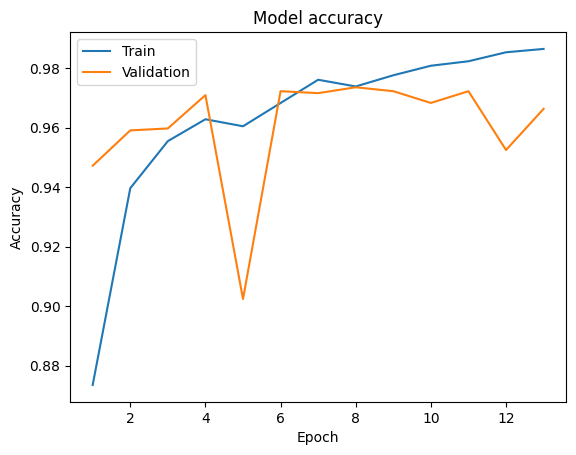

Salvato grafico di accuracy in: /content/drive/MyDrive/AAoMC/model/myVGG16/accuracy_plot.png


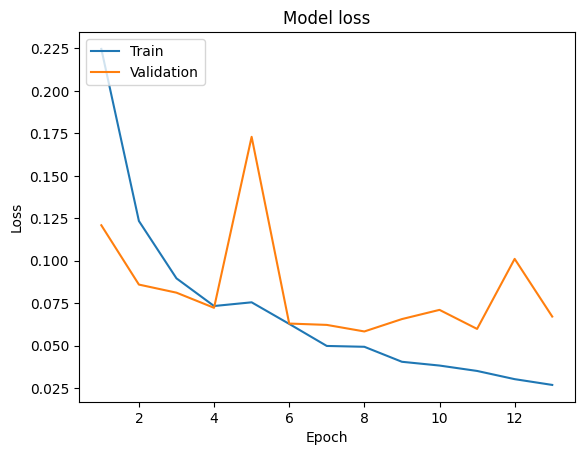

Salvato grafico di loss in: /content/drive/MyDrive/AAoMC/model/myVGG16/loss_plot.png


In [15]:
train_model(model, model_path, train_gen, val_gen, epochs=50)

#TEST PERFORMANCE

In [102]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Generazione delle predizioni sul dataset di validazione
y_pred = model.predict(test_gen)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step


In [112]:
print(test_gen.class_indices)

{'covid': 0, 'normal': 1, 'viral_pneumonia': 2}


In [115]:
# Creazione degli array per ogni classe
normal = {'normal': [], 'viral_pneumonia': [], 'covid': []}
viral_pneumonia = {'normal': [], 'viral_pneumonia': [], 'covid': []}
covid = {'normal': [], 'viral_pneumonia': [], 'covid': []}

# Conversione delle predizioni in classi
predicted_classes = np.argmax(y_pred, axis=1)

# Associazione dei path alle predizioni
for i, (pred, true) in enumerate(zip(predicted_classes, y_true)):

    image_path = test_gen.filepaths[i]

    if true == 1:  # Normal
        if pred == 1:
            normal['normal'].append(image_path)
        elif pred == 2:
            normal['viral_pneumonia'].append(image_path)
        elif pred == 0:
            normal['covid'].append(image_path)

    elif true == 2:  # Viral Pneumonia
        if pred == 2:
            viral_pneumonia['viral_pneumonia'].append(image_path)
        elif pred == 1:
            viral_pneumonia['normal'].append(image_path)
        elif pred == 0:
            viral_pneumonia['covid'].append(image_path)

    elif true == 0:  # COVID
        if pred == 0:
            covid['covid'].append(image_path)
        elif pred == 1:
            covid['normal'].append(image_path)
        elif pred == 2:
            covid['viral_pneumonia'].append(image_path)

print(f"NORMAL: {len(normal['normal'])}, {len(normal['viral_pneumonia'])}, {len(normal['covid'])}")
print(f"VIRAL:  {len(viral_pneumonia['normal'])}, {len(viral_pneumonia['viral_pneumonia'])}, {len(viral_pneumonia['covid'])}")
print(f"COVID:  {len(covid['normal'])}, {len(covid['viral_pneumonia'])}, {len(covid['covid'])}")


NORMAL: 1956, 1, 40
VIRAL:  12, 266, 5
COVID:  23, 1, 727


In [116]:
from sklearn.metrics import classification_report, accuracy_score

# Calcolo delle metriche di valutazione
report = classification_report(y_true, predicted_classes, target_names=class_labels)
accuracy = accuracy_score(y_true, predicted_classes)

# Mostra il report di classificazione (Precision, Recall, F1-score, Support)
print("Classification Report:")
print(report)

# Mostra l'accuracy complessiva
print(f"Accuracy: {accuracy * 100:.2f}%")

Classification Report:
                 precision    recall  f1-score   support

          covid       0.94      0.97      0.95       751
         normal       0.98      0.98      0.98      1997
viral_pneumonia       0.99      0.94      0.97       283

       accuracy                           0.97      3031
      macro avg       0.97      0.96      0.97      3031
   weighted avg       0.97      0.97      0.97      3031

Accuracy: 97.29%


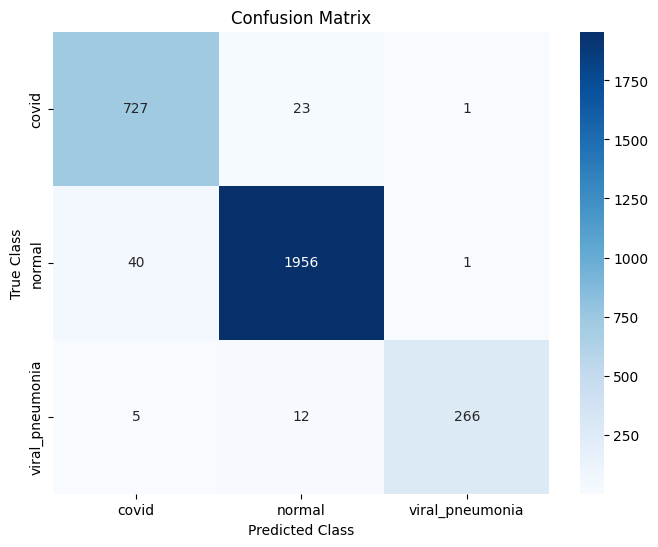

In [117]:
# Visualizzazione della matrice di confusione
conf_matrix = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

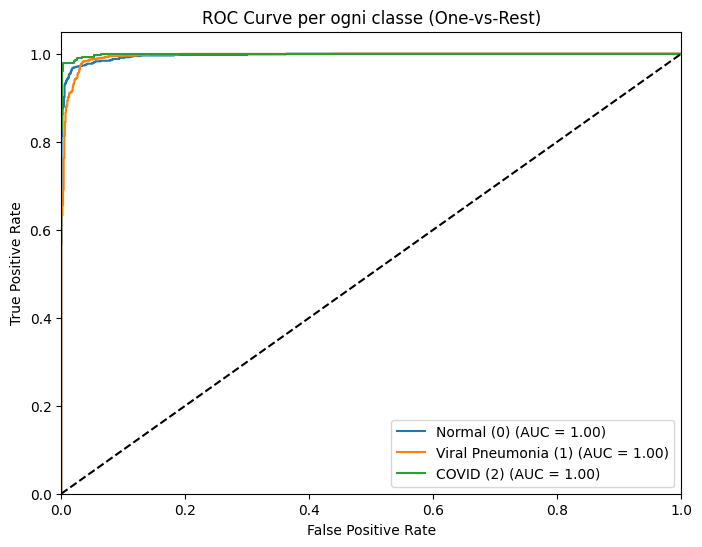

In [118]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarizzazione delle etichette in modo che possano essere usate con ROC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Etichette delle classi
class_labels = ['Normal (0)', 'Viral Pneumonia (1)', 'COVID (2)']

# Calcolo delle ROC curve e dell'AUC
fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # Area Under the Curve (AUC)

# Calcoliamo la ROC e AUC per ciascuna classe
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot delle ROC curves per ogni classe
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Linea di riferimento diagonale
plt.plot([0, 1], [0, 1], 'k--')

# Impostazioni del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per ogni classe (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


In [123]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(image_path, true_label, model, class_labels=['covid','normal','viral_pneumonia'], target_size=(224, 224)):
    # Carica l'immagine
    img = load_img(image_path, target_size=target_size)

    # Mostra l'immagine
    plt.imshow(img)
    plt.axis('off')  # Nasconde gli assi

    # Pre-processa l'immagine per il modello
    img_array = img_to_array(img)  # Converte in array
    img_array = np.expand_dims(img_array, axis=0)  # Aggiunge una dimensione per il batch
    img_array = img_array / 255.0  # Normalizza l'immagine (se il modello richiede normalizzazione)

    # Predici la classe dell'immagine
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Recupera il valore vero e quello predetto
    predicted_label = class_labels[predicted_class]
    true_label_str = class_labels[true_label]

    # Titolo con i valori vero e predetto
    plt.title(f'Vero: {true_label_str}, Predetto: {predicted_label}')

    # Mostra l'immagine con titolo
    plt.show()

# Esempio di utilizzo del metodo:
# class_labels = ['Normal', 'Viral Pneumonia', 'COVID']  # Classi possibili
# image_path = 'path/to/image.jpg'  # Inserisci il percorso dell'immagine
# true_label = 0  # Inserisci l'etichetta vera (ad esempio, 0 per Normal)
# classify_and_display_image(image_path, true_label, model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


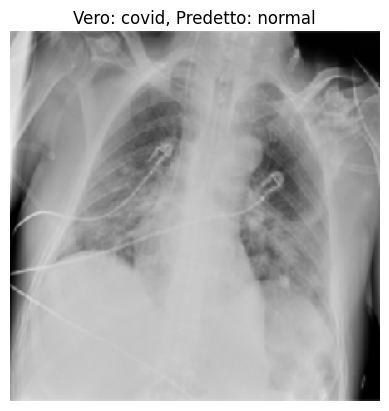

'/content/estrazione/COVID/images/COVID-3469.png'

In [124]:
predict_image(covid['normal'][0],0,model)
covid['normal'][0]

#GRAD-CAM

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


def get_conv_layer_names(model):
    """
    Extracts the names of all convolutional layers in the given Keras model.

    Parameters:
    model (tf.keras.Model): The pre-trained Keras model.

    Returns:
    list: A list of convolutional layer names.
    """
    conv_layers = []

    # Iterate through the layers in the model
    for layer in model.layers:
        # Check if the layer is a convolutional layer
        if 'conv' in layer.name:
            conv_layers.append(layer.name)

    return conv_layers

# Example usage:
# Assuming 'model' is your loaded Keras model
#conv_layer_names = get_conv_layer_names(model)
#print(conv_layer_names)


#conv_layers = get_conv_layer_names(model)
#print(conv_layers)

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Funzione per caricare e preprocessare un'immagine data la sua path.

    Args:
        img_path (str): Il percorso dell'immagine.
        target_size (tuple): La dimensione di destinazione per il ridimensionamento dell'immagine.

    Returns:
        img_array (numpy.ndarray): L'immagine preprocessata come input per la funzione make_gradcam_heatmap.
    """
    # Carica l'immagine dal percorso
    img = image.load_img(img_path, target_size=target_size)

    # Converti l'immagine in un array
    img_array = image.img_to_array(img)

    # Aggiungi una dimensione per rappresentare il batch
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocessa l'immagine (ad esempio per MobileNet, o sostituisci con la preprocessione appropriata)
    #img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    img_array = img_array / 255.0


    return img_array



def gradcam(img_path, model, conv_layers=None, talkative=0):
    """
    Applies Grad-CAM to visualize the regions of the image that contribute to the predictions
    for the specified convolutional layers.
    """

    # Preprocess the input image for Grad-CAM
    img_array = preprocess_image(img_path)
    full_heatmap = []

    if conv_layers is None:
        conv_layers = get_conv_layer_names(model)

    for layer in conv_layers:
        # Create a new model that outputs the activations of the convolutional layer and the final predictions
        new_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer).output, model.outputs])

        with tf.GradientTape() as tape:
            # Forward pass
            last_conv_layer_output, preds = new_model(img_array)
            preds = preds[0]

            # Get the predicted class index
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # Compute the gradients of the class channel with respect to the output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # Pool the gradients across the width and height dimensions
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Compute the heatmap
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Debug: Verifica valori della heatmap
        if (talkative): print(f"Heatmap for layer {layer}: min = {np.min(heatmap)}, max = {np.max(heatmap)}")

        # Post-process the heatmap: remove negative values and normalize
        heatmap = np.maximum(heatmap, 0)  # ReLU to ensure only positive values
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalize between 0 and 1

        full_heatmap.append(heatmap)

    # Load and preprocess the original image
    img_loaded = image.load_img(img_path, target_size=(224, 224))
    img = np.array(img_loaded)

    # Convert heatmaps to 8-bit format and apply the 'jet' colormap
    full_heatmap = [np.uint8(255 * heatmap) for heatmap in full_heatmap]
    jet = plt.colormaps.get_cmap("jet")  # Updated colormap function

    jet_heatmaps = []
    for heatmap in full_heatmap:
        # Apply the colormap to the heatmap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Convert to image format and resize to match the original image dimensions
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = np.array(jet_heatmap)
        jet_heatmaps.append(jet_heatmap)

    # Number of heatmaps to display
    num_heatmaps = len(jet_heatmaps)

    # Create a figure to display the original image, heatmaps, and superimposed image
    fig, axes = plt.subplots(1, num_heatmaps + 2, figsize=(5 * (num_heatmaps + 2), 6))

    # Display the original image
    axes[0].imshow(img.astype("uint8"))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the heatmaps
    for i in range(num_heatmaps):
        axes[i + 1].imshow(jet_heatmaps[i].astype("uint8"))
        axes[i + 1].set_title(f"Grad-CAM Heatmap {i+1}")
        axes[i + 1].axis('off')

    # Superimpose the last heatmap on the original image
    final_heatmap = jet_heatmaps[-1]
    superimposed_img = np.uint8(final_heatmap * 0.4 + img * 0.6)
    axes[num_heatmaps + 1].imshow(superimposed_img)
    axes[num_heatmaps + 1].set_title("Final Result")
    axes[num_heatmaps + 1].axis('off')

    plt.show()


In [128]:
import random

def display_grad(iterations, layers = ['block1_conv2','block2_conv2','block3_conv3','block4_conv3','block5_conv3'] ):
  for classes in ['normal','viral_pneumonia','covid']:
    print(classes + ": ")
    for prediction in ['normal','viral_pneumonia','covid']:
      print(" predicted as " + prediction + ": ")
      batch = iterations
      for i in range(batch):
        if (classes == "normal"):
          if i < len(normal[prediction]):
            img = random.choice(normal[prediction])
            print(img)
            gradcam(img,model,layers)
        if (classes == "viral_pneumonia"):
          if i < len(viral_pneumonia[prediction]):
            img = random.choice(viral_pneumonia[prediction])
            print(img)
            gradcam(img,model,layers)
        if (classes == "covid"):
          if i < len(covid[prediction]):
            img = random.choice(covid[prediction])
            print(img)
            gradcam(img,model,layers)

In [129]:
display_grad(5,['block5_conv3'])

Output hidden; open in https://colab.research.google.com to view.

In [130]:
display_grad(1)

Output hidden; open in https://colab.research.google.com to view.

#LIME

In [131]:
!pip install tensorflow keras opencv-python matplotlib seaborn lime shap grad-cam

In [132]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Funzione per applicare LIME su un'immagine
def lime(image, model, samples=500, features=5):
    explainer = lime_image.LimeImageExplainer()
    img = preprocess_image(image)

    # Esegui LIME
    explanation = explainer.explain_instance(img[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=samples)
    # Visualizzazione della spiegazione
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=features, hide_rest=False)


    # Visualizza l'immagine con i bordi del segmento evidenziati
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()
    return explanation



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

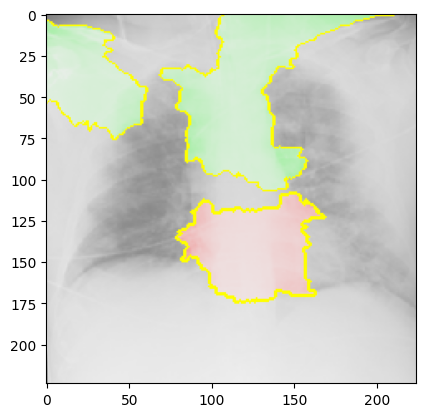

In [141]:
# Applica LIME all'immagine
exp = lime(covid['covid'][5], model, samples=1000)

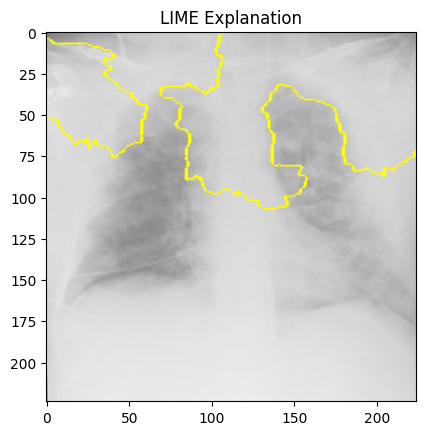

In [134]:
temp, mask = exp.get_image_and_mask(
    exp.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Visualizza l'immagine con la maschera
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.show()

In [135]:
# Ottieni l'importanza dei superpixel per la predizione
label = exp.top_labels[0]  # La label della classe predetta
importance_info = exp.local_exp[label]  # Local explanations per la classe

# Visualizza i superpixel con i rispettivi pesi
print("Superpixel e loro pesi (importanza):")
for superpixel, weight in importance_info:
    print(f"Superpixel {superpixel} ha un peso di {weight}")


Superpixel e loro pesi (importanza):
Superpixel 3 ha un peso di 0.23145750823395042
Superpixel 6 ha un peso di 0.15283767835813236
Superpixel 4 ha un peso di 0.1166522277196414
Superpixel 11 ha un peso di 0.10819814545875214
Superpixel 1 ha un peso di 0.10251515306250455
Superpixel 19 ha un peso di -0.10223162732753081
Superpixel 26 ha un peso di -0.09867287745574288
Superpixel 10 ha un peso di 0.09748946132198788
Superpixel 18 ha un peso di -0.09614999759578367
Superpixel 16 ha un peso di -0.08683276879109816
Superpixel 5 ha un peso di 0.07142799561017248
Superpixel 22 ha un peso di -0.06170022137986268
Superpixel 25 ha un peso di -0.05949993534319488
Superpixel 12 ha un peso di -0.04756022919576534
Superpixel 14 ha un peso di 0.04659922080526492
Superpixel 24 ha un peso di -0.035766852299090546
Superpixel 21 ha un peso di 0.03044213595449424
Superpixel 17 ha un peso di 0.030370703633715905
Superpixel 0 ha un peso di -0.028548160449917436
Superpixel 7 ha un peso di 0.02714836181775679

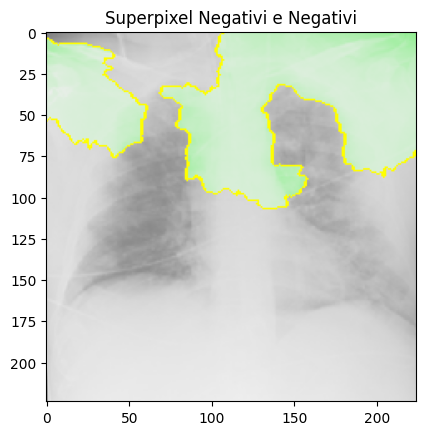

In [136]:
# Visualizzazione: superpixel con contributo positivo e negativo
temp, mask = exp.get_image_and_mask(label, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("Superpixel Negativi e Negativi")
plt.show()


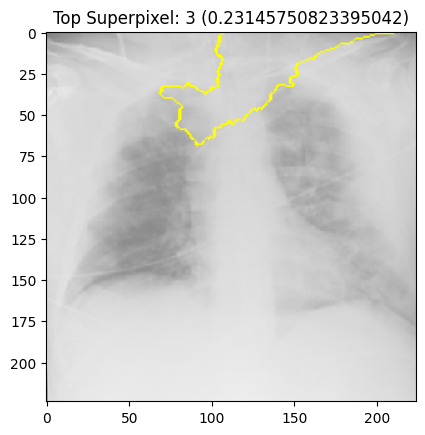

In [137]:
temp, mask = exp.get_image_and_mask(label, positive_only=True, num_features=1, hide_rest=False)
plt.figure()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"Top Superpixel: {importance_info[0][0]} ({importance_info[0][1]})")
plt.show()

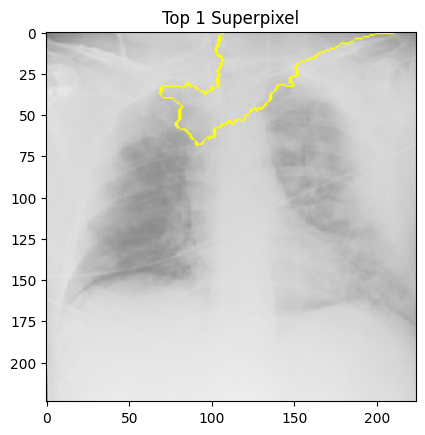

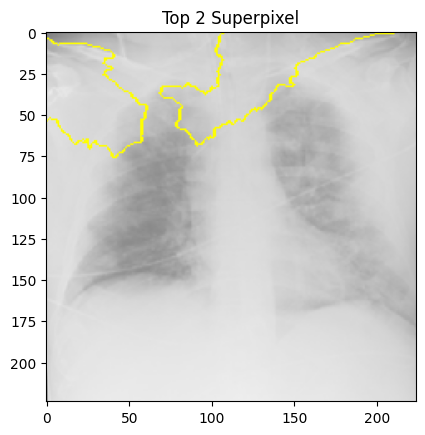

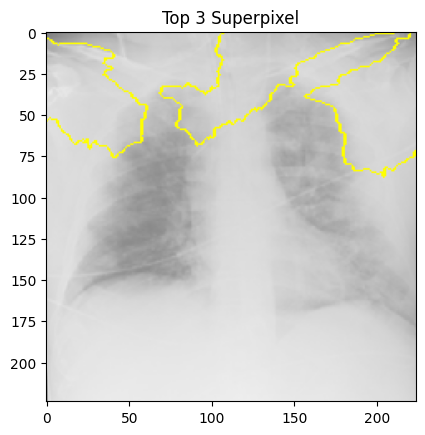

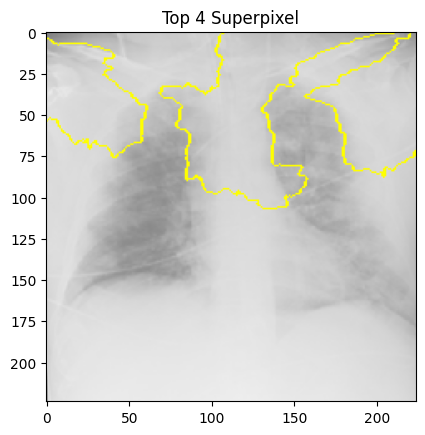

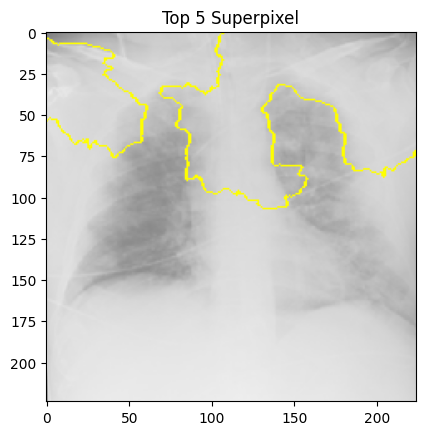

In [138]:
# Itera attraverso i superpixel più rilevanti (basato su `features`)
for i in range(1, 5 + 1):
    temp, mask = exp.get_image_and_mask(label, positive_only=True, num_features=i, hide_rest=False)
    plt.figure()
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Top {i} Superpixel")
    plt.show()


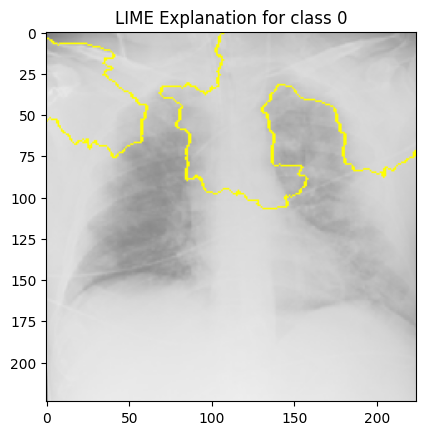

In [139]:
# Visualizza tutte le maschere per ogni label predetta
for label in exp.top_labels:
    temp, mask = exp.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"LIME Explanation for class {label}")
    plt.show()


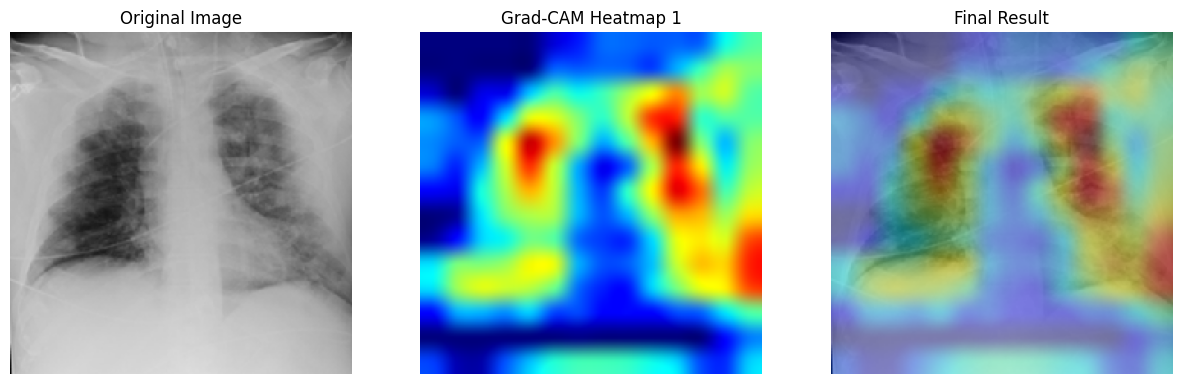

In [140]:
gradcam(covid['covid'][5],model,['block5_conv3'])

#SHAP

In [87]:
!pip install shap
import shap


In [88]:
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
import numpy as np
import matplotlib.pyplot as plt

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Number of ImageNet classes: 1000
Class names: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_const

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:02, 31.41s/it]


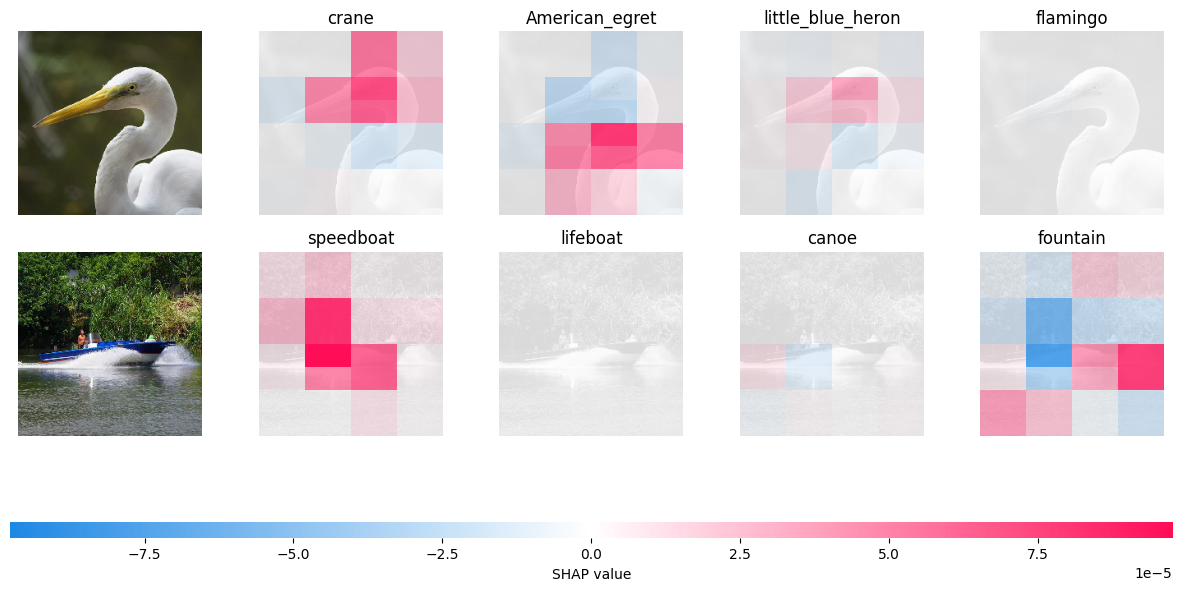

In [ ]:
# load pre-trained model and data
model = ResNet50(weights="imagenet")
X, y = shap.datasets.imagenet50()

# Assuming X[8] contains integer data that needs to be scaled to the range [0, 255]
X = np.clip(X, 0, 255).astype(np.uint8)

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

print("Number of ImageNet classes:", len(class_names))
print("Class names:", class_names)

def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

# output with shap values
shap.image_plot(shap_values)

Image Path: /content/estrazione/dataset/CR.1.2.840.113564.1722810170.20200318082923328940.1003000225002.png, Label: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


PartitionExplainer explainer: 2it [01:23, 83.62s/it]               


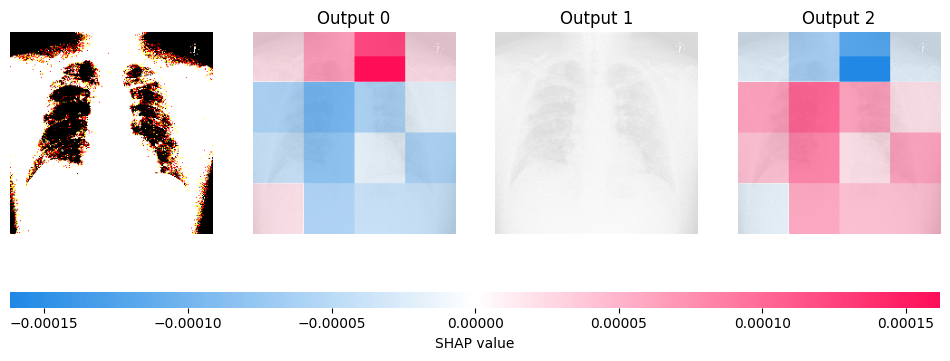

In [ ]:
import shap
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


# Funzione per caricare e preprocessare un'immagine
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

# Carica l'immagine dal primo percorso (X contiene i percorsi delle immagini)
img_path = paths[0]  # Il primo percorso di immagine
X = load_and_preprocess_image(img_path)

# Mostra le etichette corrispondenti (ad esempio, label[0])
y = labels[0]
print(f"Image Path: {img_path}, Label: {y}")

# Funzione di predizione
def f(x):
    return model.predict(x)

# Applica SHAP
# Definisci un masker che maschera le parti dell'immagine
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# Crea un explainer con il modello e il masker delle immagini
explainer = shap.Explainer(f, masker)

# Calcola i valori SHAP per l'immagine
shap_values = explainer(X, max_evals=100, batch_size=50)

# Visualizza i valori SHAP
def normalize_image(img):
    return (img - img.min()) / (img.max() - img.min())

img_normalized = normalize_image(X)  # Normalizza l'immagine preprocessata
shap.image_plot(shap_values, img_normalized)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/98 [00:00<?, ?it/s]

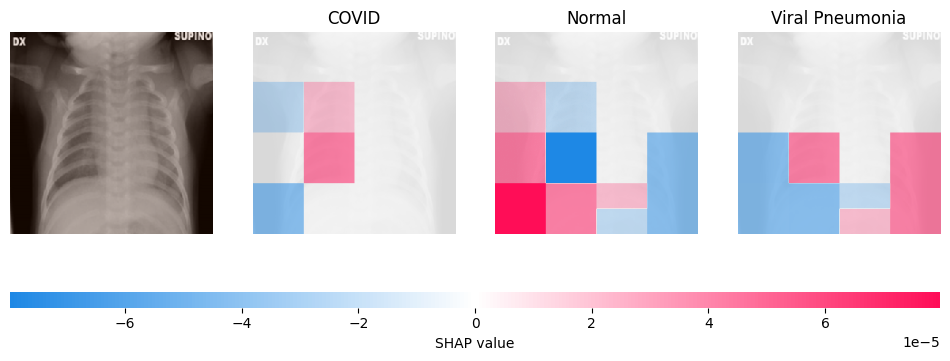

In [149]:
import shap
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Funzione per caricare e preprocessare un'immagine
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

# Carica l'immagine dal primo percorso (X contiene i percorsi delle immagini)
img_path = covid['viral_pneumonia'][0]  # Il primo percorso di immagine
X = load_and_preprocess_image(img_path)


# Definisci i nomi delle classi
class_names = ['COVID', 'Normal', 'Viral Pneumonia']

# Funzione di predizione
def f(x):
    return model.predict(x)

# Applica SHAP
# Definisci un masker che maschera le parti dell'immagine
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# Crea un explainer con il modello e il masker delle immagini
explainer = shap.Explainer(f, masker)

# Calcola i valori SHAP per l'immagine
shap_values = explainer(X, max_evals=100, batch_size=50)

# Visualizza i valori SHAP con le etichette
def normalize_image(img):
    return (img - img.min()) / (img.max() - img.min())

img_normalized = normalize_image(X)  # Normalizza l'immagine preprocessata

# Visualizza i valori SHAP con le etichette corrette
shap.image_plot(shap_values, img_normalized, labels=class_names)


In [101]:
for img in normal['covid']:
  print(img)

/content/estrazione/COVID/images/COVID-1595.png
